In [1]:
# Test migration history reconstruction on simulated data

import sys
import os

repo_dir = "/Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/met_history_prediction/"
os.chdir(repo_dir)
from src.lib import vertex_labeling

from src.util import data_extraction_util as data_util
from src.util import vertex_labeling_util as vert_util
import matplotlib
import torch

MACHINA_DATA_DIR = os.path.join(repo_dir, 'src/data/machina_sims')


15:31:03 INFO
NumExpr defaulting to 8 threads.


CUDA GPU: False
CUDA GPU: False
CUDA GPU: False


In [26]:
#custom_colors = [matplotlib.colors.to_hex(c) for c in ['limegreen', 'cornflowerblue', 'hotpink', 'grey', 'saddlebrown', 'darkorange', 'purple', 'red', 'black', 'black', 'black', 'black']]
custom_colors = ["#6aa84fff","#c27ba0ff", "#be5742e1", "#6fa8dcff", "#e69138ff", "#9e9e9eff", 'mediumpurple', 'goldenrod', 'orangered', 'darkgreen', 'lightseagreen', 'black']
def find_labelings_all_mutation_trees(cluster_fn, all_mut_trees_fn, ref_var_fn, use_gen_dist=False):
    cluster_label_to_idx = data_util.get_cluster_label_to_idx(cluster_fn, ignore_polytomies=True)
    data = data_util.get_adj_matrices_from_all_mutation_trees(all_mut_trees_fn, cluster_label_to_idx, is_sim_data=True)
    print("num trees:", len(data))
    i = 1
    for adj_matrix, pruned_cluster_label_to_idx in data:
        print(f"TREE {i}")
        T = torch.tensor(adj_matrix, dtype = torch.float32)
        B = vert_util.get_mutation_matrix_tensor(T)
        ref_matrix, var_matrix, unique_sites= data_util.get_ref_var_matrices_from_machina_sim_data(ref_var_fn, 
                                                                                                   pruned_cluster_label_to_idx=pruned_cluster_label_to_idx,
                                                                                                   T=T)
        G = data_util.get_genetic_distance_tensor_from_sim_adj_matrix(T, pruned_cluster_label_to_idx)
        G = G if use_gen_dist else None
        print("G\n", G)
        idx_to_label = {v:k for k,v in pruned_cluster_label_to_idx.items()}
        print(idx_to_label)
        print(unique_sites)   
        primary_idx = unique_sites.index('P')
        r = torch.nn.functional.one_hot(torch.tensor([primary_idx]), num_classes=len(unique_sites)).T
        weights = vertex_labeling.Weights(data_fit=1.0, mig=10.0, comig=5.0, seed_site=1.0, reg=1.0, gen_dist=0.5)
        print_config = vert_util.PrintConfig(visualize=True, verbose=True, viz_intermeds=False)
        vertex_labeling.gumbel_softmax_optimization(T, ref_matrix, var_matrix, B, ordered_sites=unique_sites, 
                                                    weights=weights, p=r, node_idx_to_label=idx_to_label, G=G,
                                                    batch_size=16, init_temp=30, final_temp=0.01, 
                                                    print_config=print_config, custom_colors=custom_colors)
        print("*"*100)
        i += 1

import pydot
from IPython.display import Image, display

def visualize_ground_truth(tree_fn, graph_fn):
    def view_pydot(pdot):
        plt = Image(pdot.create_png())
        display(plt)
    
    (graph,) = pydot.graph_from_dot_file(tree_fn)
    view_pydot(graph)

    (graph,) = pydot.graph_from_dot_file(graph_fn)
    view_pydot(graph)
        
        

Ground truth


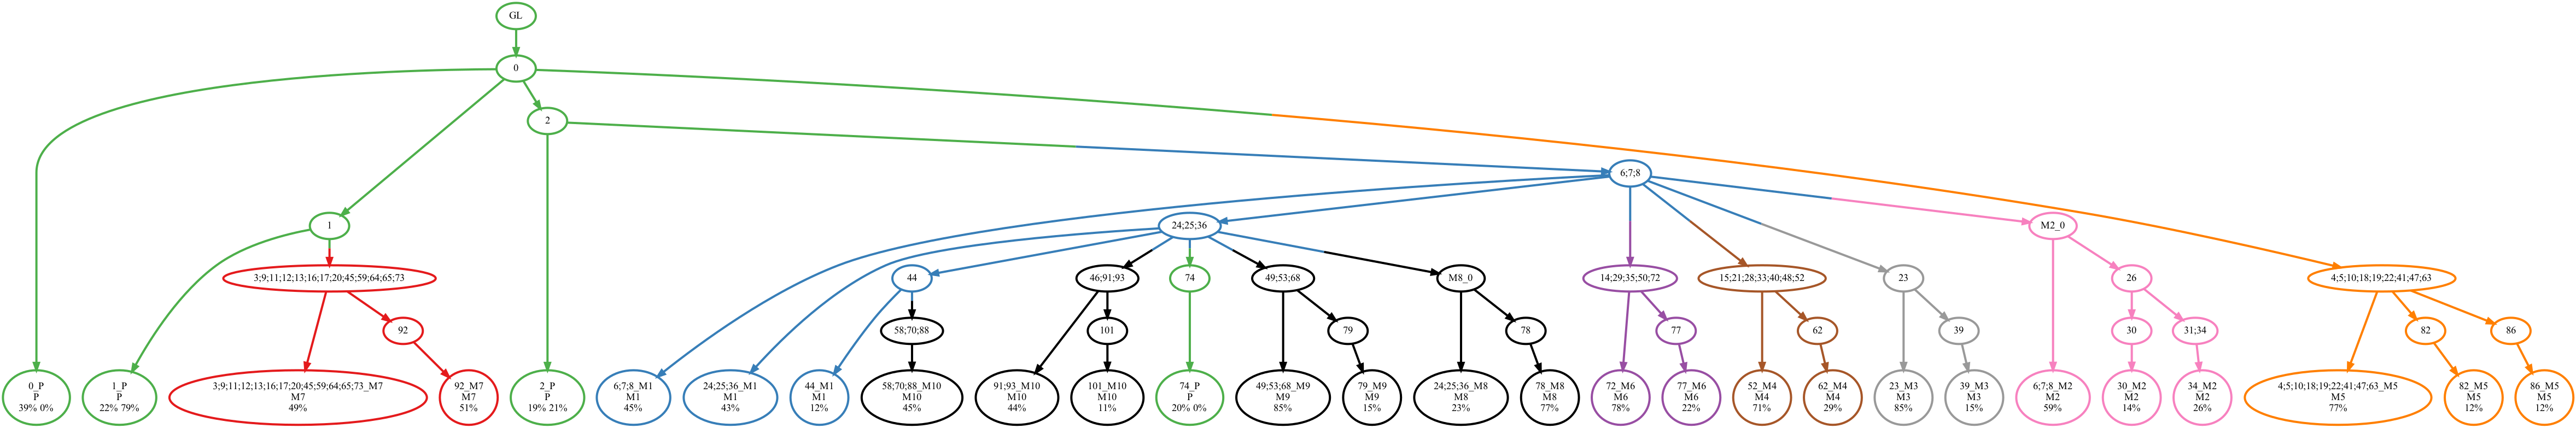

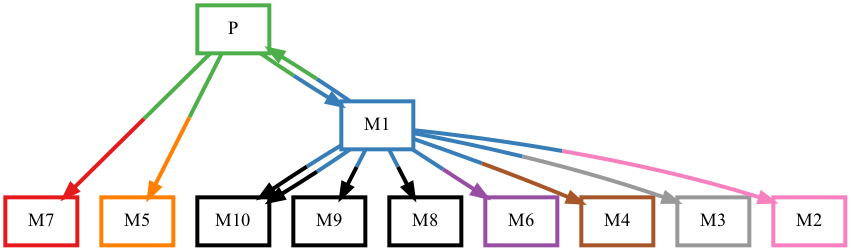

In [27]:
num_sites = "m8"
mig_type = "R"
SEED = 157
SIM_DATA_DIR = os.path.join(MACHINA_DATA_DIR, num_sites, mig_type)

print("Ground truth")
visualize_ground_truth(os.path.join(SIM_DATA_DIR, f"T_seed{SEED}.dot"), os.path.join(SIM_DATA_DIR, f"G_seed{SEED}.dot"))


num trees: 48
TREE 1
G
 None
{0: '0', 1: '1', 2: '2', 3: '6;7;8', 4: '23', 5: '26;30;31;34', 6: '24;25;36', 7: '39', 8: '44', 9: '15;21;28;33;40;48;52', 10: '62', 11: '4;5;10;18;19;22;41;47;63', 12: '49;53;68', 13: '14;29;35;50;72', 14: '74', 15: '77', 16: '78', 17: '79', 18: '82;86', 19: '3;9;11;12;13;16;17;20;45;59;64;65;73;92', 20: '46;58;70;88;91;93;101'}
['P', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10']


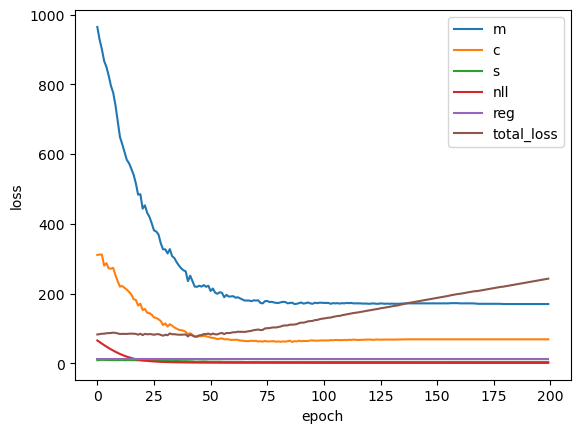

Time elapsed: 6.777108
print_config.k_best_trees 1
****************************** BEST TREE ******************************

Migration number: 17.0
Comigration number: 13.0
Seeding site number: 4.0
Neg log likelihood: 1.004
Reg: 11.0
Loss: 251.004


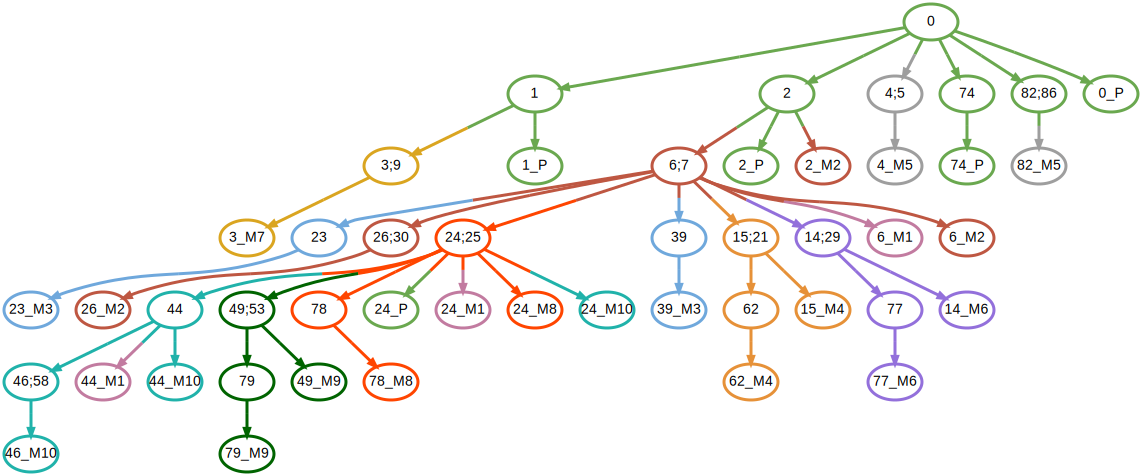

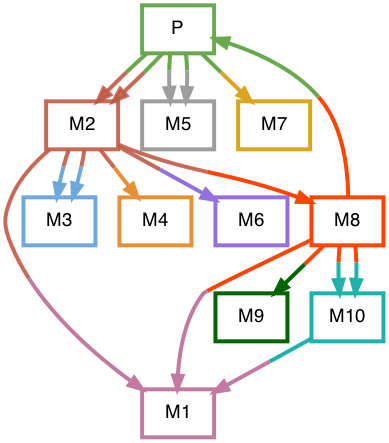

losses tensor
 tensor([256.0147, 251.0134, 256.0180, 256.0156, 255.9996, 256.0214, 251.0087,
        256.0051, 256.0041, 251.0095, 256.0033, 256.0140, 251.0040, 256.0120,
        255.9976, 256.0142]) tensor([0.0591, 0.0727, 0.0591, 0.0591, 0.0591, 0.0591, 0.0727, 0.0591, 0.0591,
        0.0727, 0.0591, 0.0591, 0.0727, 0.0591, 0.0591, 0.0591])
avg_node_colors
 {'  0  ': {0: tensor(1.)}, '  1  ': {0: tensor(1.)}, '  2  ': {0: tensor(1.)}, ' 4;5 ': {5: tensor(1.)}, '  74 ': {0: tensor(1.)}, '82;86': {0: tensor(0.4947), 5: tensor(0.5053)}, ' 0_P ': {0: tensor(1.)}, ' 3;9 ': {7: tensor(1.)}, ' 1_P ': {0: tensor(1.)}, ' 6;7 ': {2: tensor(0.5516), 3: tensor(0.4484)}, ' 2_P ': {0: tensor(1.)}, ' 2_M2': {2: tensor(1.)}, '  23 ': {3: tensor(1.)}, '26;30': {2: tensor(1.)}, '24;25': {8: tensor(1.)}, '  39 ': {3: tensor(1.)}, '15;21': {4: tensor(1.)}, '14;29': {6: tensor(1.)}, ' 6_M1': {1: tensor(1.)}, ' 6_M2': {2: tensor(1.)}, '23_M3': {3: tensor(1.)}, '26_M2': {2: tensor(1.)}, '  44 ': {10: tenso

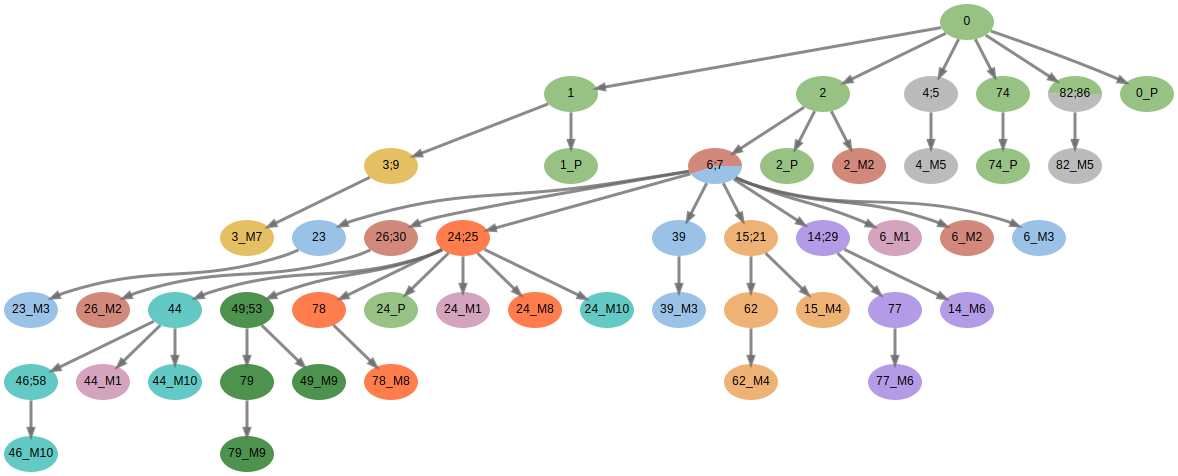

****************************************************************************************************
TREE 2
G
 None
{0: '0', 1: '1', 2: '2', 3: '6;7;8', 4: '23', 5: '26;30;31;34', 6: '24;25;36', 7: '39', 8: '44', 9: '15;21;28;33;40;48;52', 10: '62', 11: '4;5;10;18;19;22;41;47;63', 12: '49;53;68', 13: '14;29;35;50;72', 14: '74', 15: '77', 16: '78', 17: '79', 18: '82;86', 19: '3;9;11;12;13;16;17;20;45;59;64;65;73;92', 20: '46;58;70;88;91;93;101'}
['P', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10']


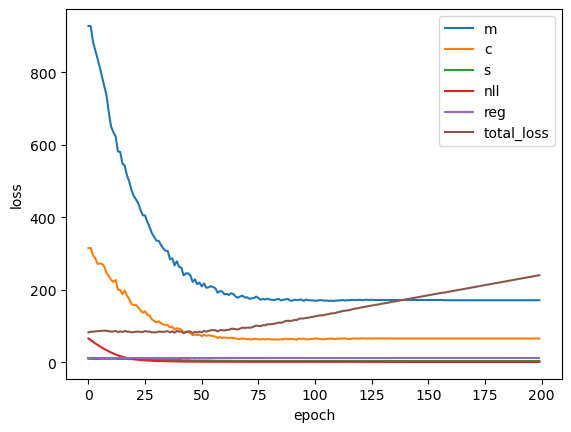

Time elapsed: 7.138211
print_config.k_best_trees 1
****************************** BEST TREE ******************************

Migration number: 17.0
Comigration number: 12.0
Seeding site number: 3.0
Neg log likelihood: 1.012
Reg: 10.999999046325684
Loss: 245.012


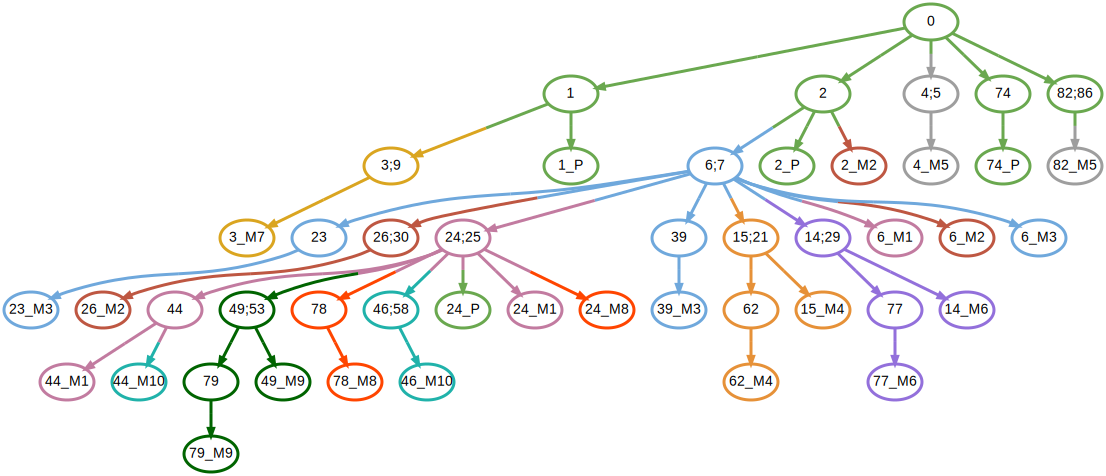

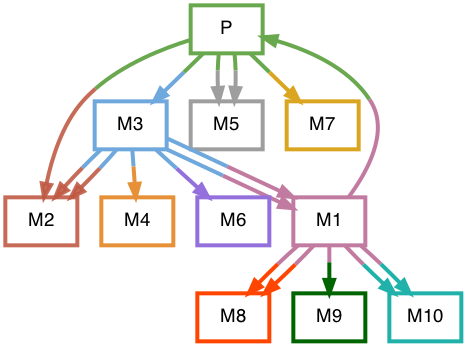

losses tensor
 tensor([256.0077, 250.0059, 251.0072, 250.0027, 250.0056, 245.0116, 250.0117,
        256.0047, 256.0149, 250.0216, 256.0151, 256.0094, 254.9988, 256.0085,
        250.0141, 250.0152]) tensor([0.0531, 0.0681, 0.0653, 0.0681, 0.0681, 0.0842, 0.0681, 0.0531, 0.0531,
        0.0681, 0.0531, 0.0531, 0.0553, 0.0531, 0.0681, 0.0681])
avg_node_colors
 {'  0  ': {0: tensor(1.)}, '  1  ': {0: tensor(1.)}, '  2  ': {0: tensor(1.)}, ' 4;5 ': {5: tensor(1.)}, '  74 ': {0: tensor(1.)}, '82;86': {0: tensor(0.5338), 5: tensor(0.4662)}, ' 3;9 ': {7: tensor(1.)}, ' 1_P ': {0: tensor(1.)}, ' 6;7 ': {3: tensor(0.4959), 2: tensor(0.5041)}, ' 2_P ': {0: tensor(1.)}, ' 2_M2': {2: tensor(1.)}, '  23 ': {3: tensor(1.)}, '26;30': {2: tensor(1.)}, '24;25': {1: tensor(0.3852), 10: tensor(0.3364), 8: tensor(0.2783)}, '  39 ': {3: tensor(1.)}, '15;21': {4: tensor(1.)}, '14;29': {6: tensor(1.)}, ' 6_M1': {1: tensor(1.)}, ' 6_M2': {2: tensor(1.)}, ' 6_M3': {3: tensor(1.)}, '23_M3': {3: tensor(1.)}, '2

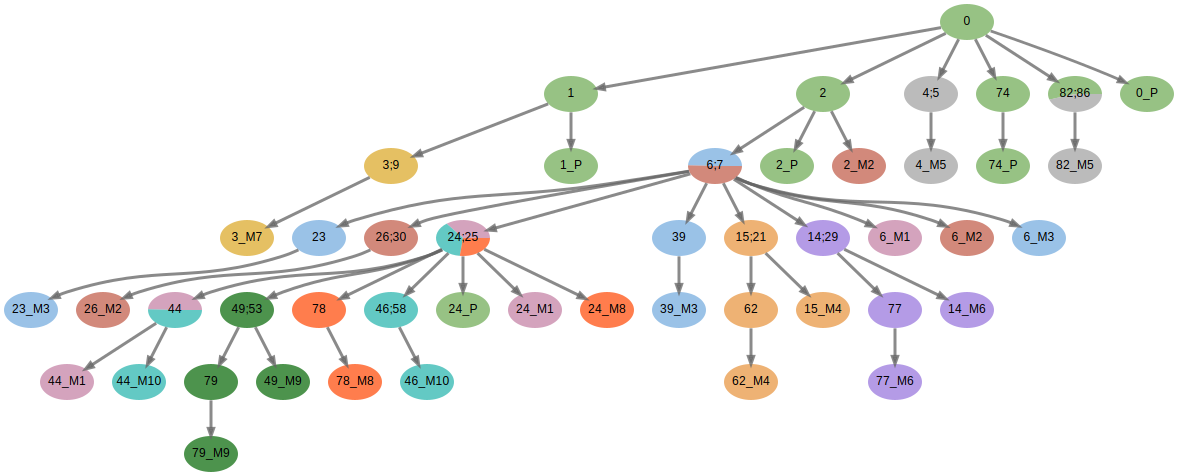

****************************************************************************************************
TREE 3
G
 None
{0: '0', 1: '1', 2: '2', 3: '6;7;8', 4: '23', 5: '26;30;31;34', 6: '24;25;36', 7: '39', 8: '44', 9: '15;21;28;33;40;48;52', 10: '62', 11: '4;5;10;18;19;22;41;47;63', 12: '49;53;68', 13: '14;29;35;50;72', 14: '74', 15: '77', 16: '78', 17: '79', 18: '82;86', 19: '3;9;11;12;13;16;17;20;45;59;64;65;73;92', 20: '46;58;70;88;91;93;101'}
['P', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10']


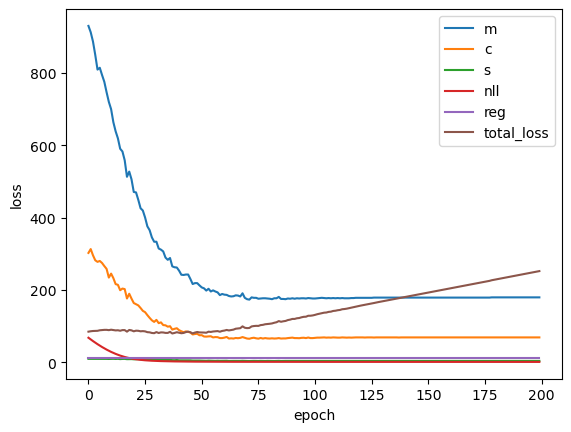

Time elapsed: 6.637336
print_config.k_best_trees 1
****************************** BEST TREE ******************************

Migration number: 17.0
Comigration number: 13.0
Seeding site number: 4.0
Neg log likelihood: 1.019
Reg: 11.000000953674316
Loss: 251.019


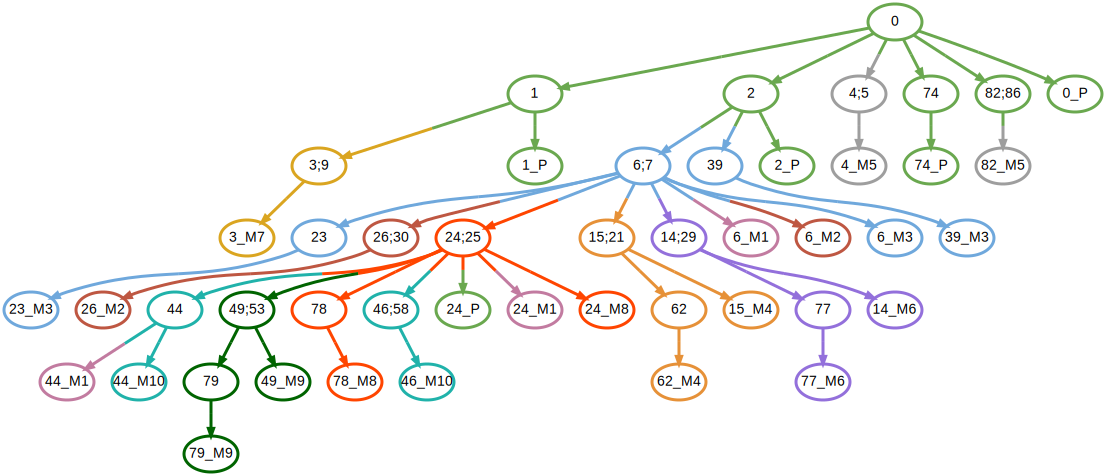

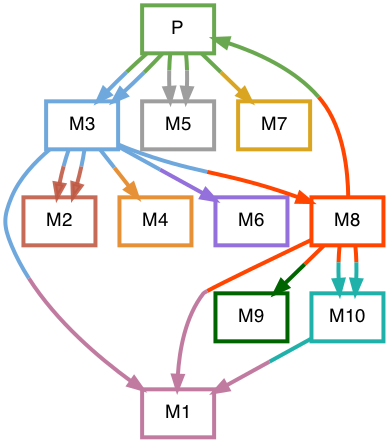

losses tensor
 tensor([266.0108, 266.0125, 266.0115, 260.0259, 266.0204, 266.0121, 266.0087,
        266.0148, 266.0245, 266.0233, 266.0197, 260.0131, 266.0170, 251.0186,
        260.0273, 266.0068]) tensor([0.0567, 0.0567, 0.0567, 0.0720, 0.0567, 0.0567, 0.0567, 0.0567, 0.0566,
        0.0566, 0.0567, 0.0720, 0.0567, 0.1042, 0.0720, 0.0567])
avg_node_colors
 {'  0  ': {0: tensor(1.)}, '  1  ': {0: tensor(1.)}, '  2  ': {0: tensor(1.)}, ' 4;5 ': {5: tensor(1.)}, '  74 ': {0: tensor(1.)}, '82;86': {0: tensor(0.5168), 5: tensor(0.4832)}, ' 0_P ': {0: tensor(1.)}, ' 3;9 ': {7: tensor(1.)}, ' 1_P ': {0: tensor(1.)}, ' 6;7 ': {3: tensor(0.5014), 2: tensor(0.4986)}, '  39 ': {3: tensor(0.5169), 0: tensor(0.4831)}, ' 2_P ': {0: tensor(1.)}, '  23 ': {3: tensor(1.)}, '26;30': {2: tensor(1.)}, '24;25': {8: tensor(0.4518), 10: tensor(0.5482)}, '15;21': {4: tensor(1.)}, '14;29': {6: tensor(1.)}, ' 6_M1': {1: tensor(1.)}, ' 6_M2': {2: tensor(1.)}, ' 6_M3': {3: tensor(1.)}, '23_M3': {3: tensor(1.)}

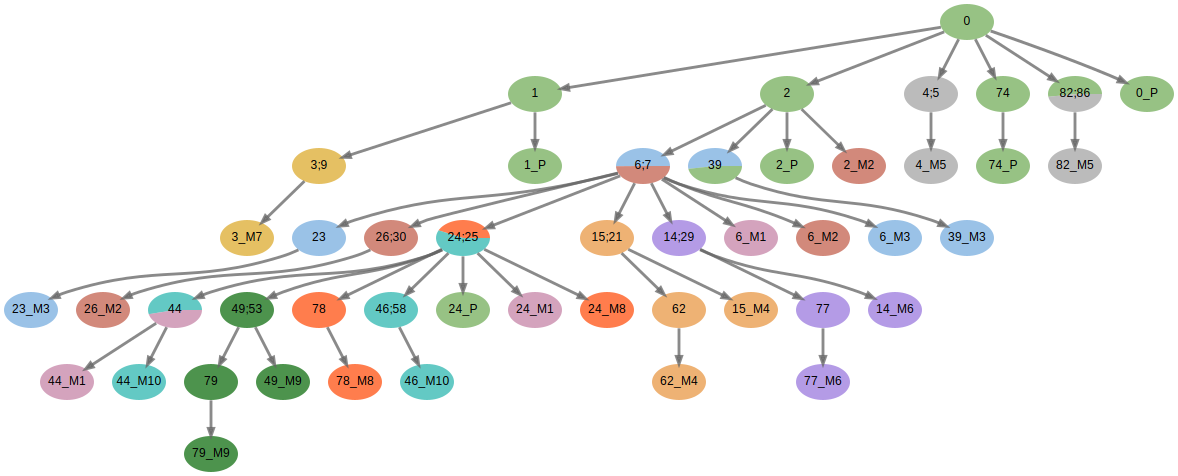

****************************************************************************************************
TREE 4
G
 None
{0: '0', 1: '1', 2: '2', 3: '6;7;8', 4: '23', 5: '26;30;31;34', 6: '24;25;36', 7: '39', 8: '44', 9: '15;21;28;33;40;48;52', 10: '62', 11: '4;5;10;18;19;22;41;47;63', 12: '49;53;68', 13: '14;29;35;50;72', 14: '74', 15: '77', 16: '78', 17: '79', 18: '82;86', 19: '3;9;11;12;13;16;17;20;45;59;64;65;73;92', 20: '46;58;70;88;91;93;101'}
['P', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10']


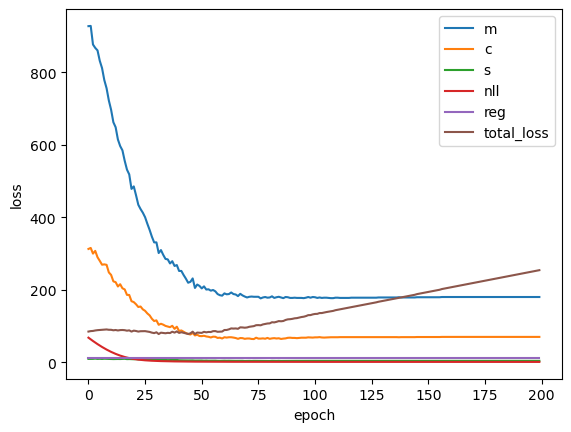

Time elapsed: 6.856839
print_config.k_best_trees 1
****************************** BEST TREE ******************************

Migration number: 18.0
Comigration number: 14.0
Seeding site number: 4.0
Neg log likelihood: 1.002
Reg: 11.0
Loss: 266.002


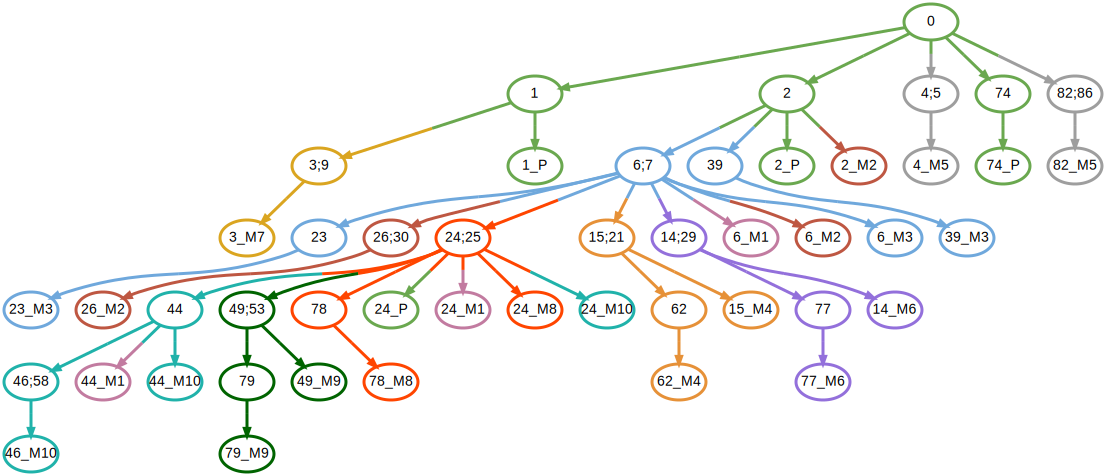

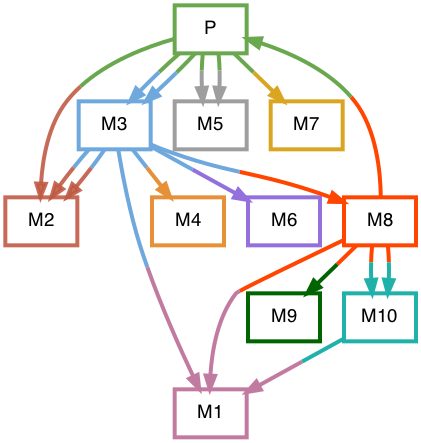

losses tensor
 tensor([266.0276, 266.0102, 266.0041, 266.0219, 266.0185, 266.0131, 266.0246,
        266.0277, 266.0021, 266.0034, 266.0165, 266.0247, 266.0136, 266.0201,
        266.0189, 266.0134]) tensor([0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
        0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625])
avg_node_colors
 {'  0  ': {0: tensor(1.)}, '  1  ': {0: tensor(1.)}, '  2  ': {0: tensor(1.)}, ' 4;5 ': {5: tensor(1.)}, '  74 ': {0: tensor(1.)}, '82;86': {5: tensor(0.5001), 0: tensor(0.4999)}, ' 3;9 ': {7: tensor(1.)}, ' 1_P ': {0: tensor(1.)}, ' 6;7 ': {3: tensor(0.5000), 2: tensor(0.5000)}, '  39 ': {3: tensor(0.5000), 0: tensor(0.5000)}, ' 2_P ': {0: tensor(1.)}, ' 2_M2': {2: tensor(1.)}, '  23 ': {3: tensor(1.)}, '26;30': {2: tensor(1.)}, '24;25': {8: tensor(1.)}, '15;21': {4: tensor(1.)}, '14;29': {6: tensor(1.)}, ' 6_M1': {1: tensor(1.)}, ' 6_M2': {2: tensor(1.)}, ' 6_M3': {3: tensor(1.)}, '23_M3': {3: tensor(1.)}, '26_M2': {2: tensor(1.

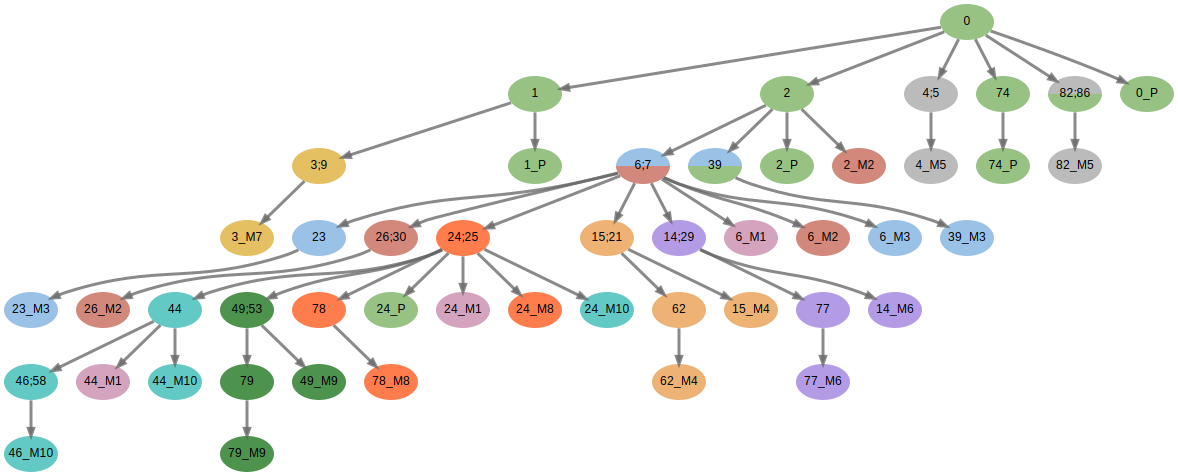

****************************************************************************************************
TREE 5
G
 None
{0: '0', 1: '1', 2: '2', 3: '6;7;8', 4: '23', 5: '26;30;31;34', 6: '24;25;36', 7: '39', 8: '44', 9: '15;21;28;33;40;48;52', 10: '62', 11: '4;5;10;18;19;22;41;47;63', 12: '49;53;68', 13: '14;29;35;50;72', 14: '74', 15: '77', 16: '78', 17: '79', 18: '82;86', 19: '3;9;11;12;13;16;17;20;45;59;64;65;73;92', 20: '46;58;70;88;91;93;101'}
['P', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10']


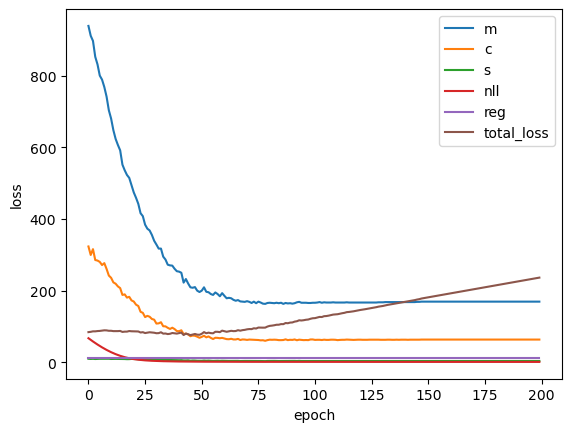

Time elapsed: 7.011879
print_config.k_best_trees 1
****************************** BEST TREE ******************************

Migration number: 17.0
Comigration number: 11.0
Seeding site number: 3.0
Neg log likelihood: 1.015
Reg: 11.0
Loss: 240.015


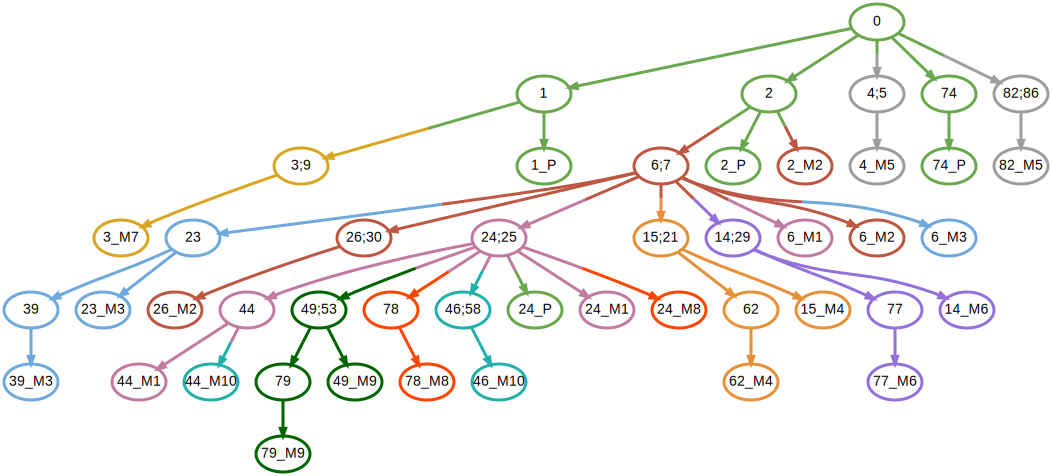

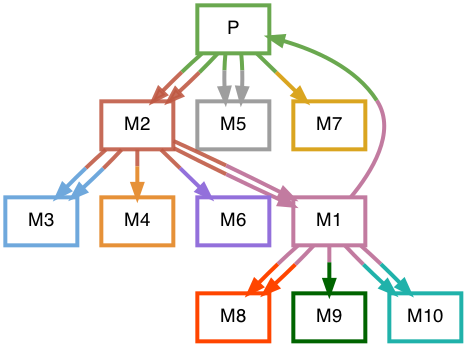

losses tensor
 tensor([256.0132, 245.0178, 244.9954, 251.0064, 251.0186, 245.0107, 251.0129,
        240.0147, 251.0073, 245.0152, 251.0149, 251.0093, 251.0089, 251.0086,
        250.0113, 241.0132]) tensor([0.0448, 0.0710, 0.0711, 0.0551, 0.0551, 0.0710, 0.0551, 0.0882, 0.0551,
        0.0710, 0.0551, 0.0551, 0.0551, 0.0551, 0.0575, 0.0844])
avg_node_colors
 {'  0  ': {0: tensor(1.)}, '  1  ': {0: tensor(1.)}, '  2  ': {0: tensor(1.)}, ' 4;5 ': {5: tensor(1.)}, '  74 ': {0: tensor(1.)}, '82;86': {5: tensor(0.4975), 0: tensor(0.5025)}, ' 3;9 ': {7: tensor(1.)}, ' 1_P ': {0: tensor(1.)}, ' 6;7 ': {2: tensor(0.5544), 3: tensor(0.4456)}, ' 2_P ': {0: tensor(1.)}, ' 2_M2': {2: tensor(1.)}, '  23 ': {3: tensor(1.)}, '26;30': {2: tensor(1.)}, '24;25': {1: tensor(0.4149), 8: tensor(0.2648), 10: tensor(0.3203)}, '15;21': {4: tensor(1.)}, '14;29': {6: tensor(1.)}, ' 6_M1': {1: tensor(1.)}, ' 6_M2': {2: tensor(1.)}, ' 6_M3': {3: tensor(1.)}, '  39 ': {3: tensor(1.)}, '23_M3': {3: tensor(1.)}, '2

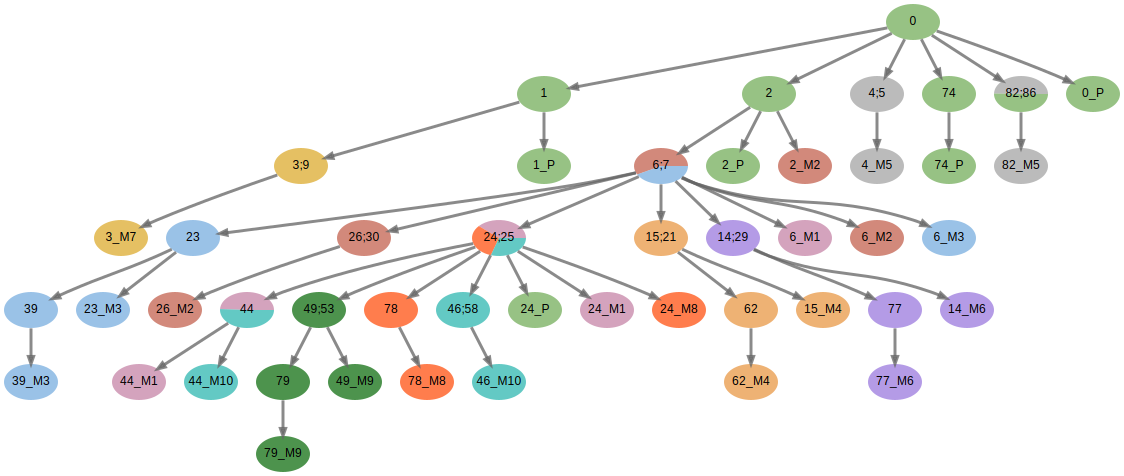

****************************************************************************************************
TREE 6
G
 None
{0: '0', 1: '1', 2: '2', 3: '6;7;8', 4: '23', 5: '26;30;31;34', 6: '24;25;36', 7: '39', 8: '44', 9: '15;21;28;33;40;48;52', 10: '62', 11: '4;5;10;18;19;22;41;47;63', 12: '49;53;68', 13: '14;29;35;50;72', 14: '74', 15: '77', 16: '78', 17: '79', 18: '82;86', 19: '3;9;11;12;13;16;17;20;45;59;64;65;73;92', 20: '46;58;70;88;91;93;101'}
['P', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10']


KeyboardInterrupt: 

In [28]:
%%time

find_labelings_all_mutation_trees(os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{SEED}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_mut_trees", f"mut_trees_{mig_type}_seed{SEED}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{SEED}.tsv"),
                                  use_gen_dist=False)




In [ ]:
import matplotlib.pyplot as plt
def f(x):
    return -1.0*(torch.log2(torch.tensor(x))/ torch.log2(torch.tensor(1.1)))
X = [x for x in range(90,110,2)]
Y = [f(x) for x in X]
print(Y)
plt.plot(X, torch.softmax(torch.tensor(Y), dim=0))

In [ ]:
%%time

find_labelings_all_mutation_trees(os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{SEED}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_mut_trees", f"mut_trees_{mig_type}_seed{SEED}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{SEED}.tsv"),
                                  use_gen_dist=True)




In [ ]:
!which python


In [ ]:
p = "/Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/met_history_prediction/src/test/machina_simulated_data/predictions_wm3_wc2_wg0.5_bs32_11032022"
p = os.path.join(p, num_sites, mig_type)
visualize_ground_truth(os.path.join(p, f"T_tree0_seed{SEED}.predicted.tree"), os.path.join(p, f"G_tree0_seed{SEED}.predicted.tree"))


In [ ]:
import fnmatch
import matplotlib.pyplot as plt
def count_trees(sims_data_dir):
    sites = ["m8", "m5"]
    mig_types = ["M", "mS", "R", "S"]
    tree_cts = []
    ct = 0
    seed_ct = 0
    for site in sites:
        for mig_type in mig_types:
            local_ct = 0
            site_mig_data_dir = os.path.join(sims_data_dir, site, mig_type)
            seeds = fnmatch.filter(os.listdir(site_mig_data_dir), 'reads_seed*.tsv')
            seeds = [s.replace(".tsv", "").replace("reads_seed", "") for s in seeds]
            for seed in seeds:
                all_mut_trees_fn = os.path.join(sims_data_dir, f"{site}_mut_trees", f"mut_trees_{mig_type}_seed{seed}.txt")
                with open(all_mut_trees_fn, 'r') as f:
                    for line in f:
                        if "#trees" in line:
                            tree_ct = int(line.split()[0])
                            tree_cts.append(tree_ct)
                            if tree_ct > 50:
                                print("tree > 50 trees", site, mig_type, seed, tree_ct)
                            ct += tree_ct
                            local_ct += tree_ct
                            break
                seed_ct += 1
            print(site, mig_type, local_ct)
    print(tree_cts)
    plt.hist(tree_cts)
    plt.show()
    plt.close()
    print("Number of total trees:", ct)

count_trees(MACHINA_DATA_DIR)
count_trees(RERUN_SIM_DIR)

In [ ]:
fn = "/Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/results_8cores_time_test.txt"
fn2 = "/Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/results_8cores_time_test2.txt"
from datetime import datetime

output = []
with open(fn) as f:
    for i,line in enumerate(f):
        items = line.strip().split(',')
        if i != 0:
            epoch_time = datetime(1900, 1, 1)
            
            secs = (datetime.strptime(items[4][items[4].find('days')+5:], "%H:%M:%S.%f") - epoch_time).total_seconds()
            #print(secs)
            items[4] = secs
            #print(items)
            output.append(items)
        else:
            output.append(items)

print(output)
import csv
with open(fn2, 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter=',', lineterminator='\n')
    for line in output:
        writer.writerow(line)

In [ ]:
mig_type = "S"
SEED = 23

RERUN_SIM_DIR = os.path.join(repo_dir, 'src/data/rerun_machina_sims')
RERUN_SIM_DATA_DIR = os.path.join(RERUN_SIM_DIR, num_sites, mig_type)

print("Manually generated sims")
visualize_ground_truth(os.path.join(RERUN_SIM_DATA_DIR, f"T_seed{SEED}.dot"), os.path.join(RERUN_SIM_DATA_DIR, f"G_seed{SEED}.dot"))


In [ ]:
import numpy as np
epoch = 10
x = max(0.01, 1.0/(1.0+np.exp(-1.0*(epoch-10))))
x
#np.max(0.01, 1.0/(1.0+np.exp(-1.0*(epoch-10))))